# Analyse de la régression logistique

Ce notebook présente des graphiques clés pour évaluer un modèle de détection de spam (régression logistique).


In [1]:
# Installation des dépendances dans le kernel du notebook
%pip install -q joblib scikit-learn pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Imports et configuration
import os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.exceptions import NotFittedError
import matplotlib.pyplot as plt
import seaborn as sns

# Style minimaliste (éco-conception): thèmes sobres, pas d'effets superflus
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "figure.dpi": 110,
    "savefig.dpi": 110,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
})

# Dans un notebook, __file__ n'est pas défini; utiliser le répertoire courant
PROJECT_DIR = Path.cwd().parent
DATA_PATH ="../data/spam.csv"
MODEL_PATH = PROJECT_DIR / "model.pkl"
REPORT_DIR = PROJECT_DIR / "reports" / "figures"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Permettre l'import des utilitaires du projet
import sys
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

print(PROJECT_DIR)



c:\Users\Yann LAVRY\Documents\GitHub\spam-detector


In [ ]:
# Chargement des données et du modèle

from utils_text import clean_texts

df = pd.read_csv(DATA_PATH)
X = clean_texts(df["Message"].astype(str))
y = df["Category"].astype(str)

# Split identique à l'entraînement
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entraîner si le modèle n'existe pas ou n'est pas fitted
import subprocess, sys
if not MODEL_PATH.exists():
    subprocess.run([sys.executable, str(PROJECT_DIR / "train.py")], check=True)

model = joblib.load(MODEL_PATH)

# Vérifier si le pipeline est fitted (ex: TfidfVectorizer.idf_)
needs_fit = False
try:
    _ = model.predict(["test"])  # test rapide
except NotFittedError:
    needs_fit = True
except Exception:
    pass

if needs_fit:
    subprocess.run([sys.executable, str(PROJECT_DIR / "train.py")], check=True)
    model = joblib.load(MODEL_PATH)

y_pred = model.predict(X_test)
y_proba = None
try:
    y_proba = model.predict_proba(X_test)[:, 1]
except Exception:
    pass

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))



c:\Users\Yann LAVRY\Documents\GitHub\checkerVenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.4.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy: 0.9740
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



c:\Users\Yann LAVRY\Documents\GitHub\checkerVenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Yann LAVRY\Documents\GitHub\checkerVenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Yann LAVRY\Documents\GitHub\checkerVenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline f

WindowsPath('c:/Users/Yann LAVRY/Documents/GitHub/spam-detector/reports/figures/confusion_matrix.png')

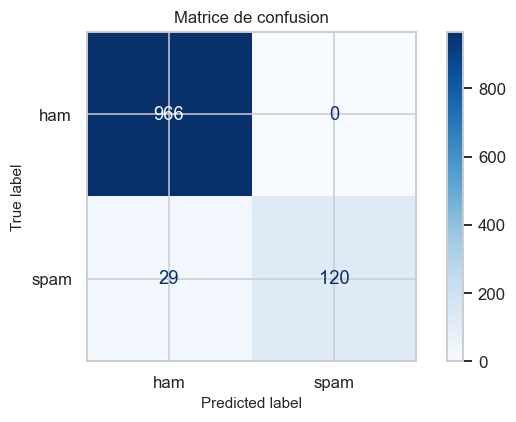

In [9]:
# Matrice de confusion
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Matrice de confusion")
plt.tight_layout()
fig_path = REPORT_DIR / "confusion_matrix.png"
plt.savefig(fig_path, bbox_inches="tight")
fig_path


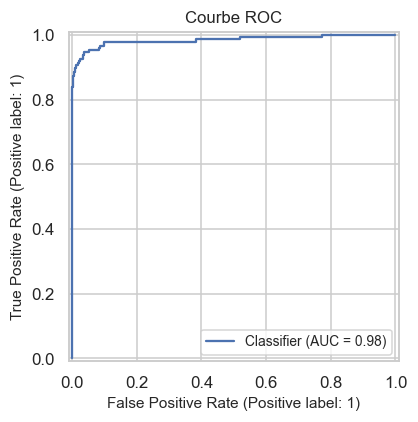

In [10]:
# Courbe ROC (si proba disponible)
if y_proba is not None:
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions((y_test == "spam").astype(int), y_proba, ax=ax)
    ax.set_title("Courbe ROC")
    plt.tight_layout()
    fig_path = REPORT_DIR / "roc_curve.png"
    plt.savefig(fig_path, bbox_inches="tight")
    fig_path
else:
    print("Probabilités non disponibles pour tracer la courbe ROC.")


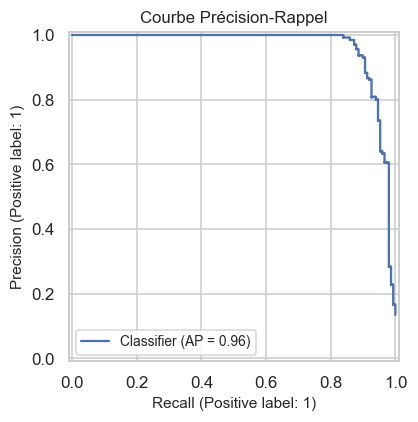

In [11]:
# Courbe Précision-Rappel (si proba disponible)
if y_proba is not None:
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions((y_test == "spam").astype(int), y_proba, ax=ax)
    ax.set_title("Courbe Précision-Rappel")
    plt.tight_layout()
    fig_path = REPORT_DIR / "pr_curve.png"
    plt.savefig(fig_path, bbox_inches="tight")
    fig_path
else:
    print("Probabilités non disponibles pour tracer la courbe PR.")


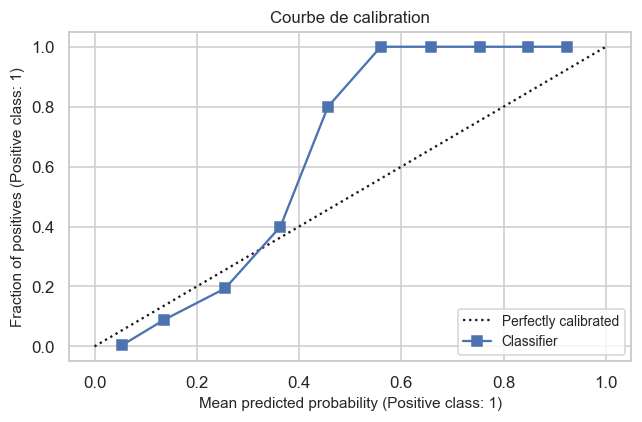

In [12]:
# Courbe de calibration (si proba disponible)
if y_proba is not None:
    fig, ax = plt.subplots()
    CalibrationDisplay.from_predictions((y_test == "spam").astype(int), y_proba, n_bins=10, ax=ax)
    ax.set_title("Courbe de calibration")
    plt.tight_layout()
    fig_path = REPORT_DIR / "calibration_curve.png"
    plt.savefig(fig_path, bbox_inches="tight")
    fig_path
else:
    print("Probabilités non disponibles pour tracer la calibration.")
